In [11]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [4]:
DATA_SOURCE = 'data/covid.zip'

In [98]:
df = pd.read_csv(DATA_SOURCE)
df.head()

,headlines,outcome
0,A post claims compulsory vacination violates t...,0
1,A photo claims that this person is a doctor wh...,0
2,Post about a video claims that it is a protest...,0
3,All deaths by respiratory failure and pneumoni...,0
4,The dean of the College of Biologists of Euska...,0


### Add feature that counts the number of words in each headlines

In [99]:
def plot_hist_by_outcome(df, col, bins=10):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    axes[0].hist(df[df['outcome'] == 0][col], bins=bins)
    axes[1].hist(df[df['outcome'] == 1][col], bins=bins)
    # subplots share the same x-axis range, and the y-axis range is automatically adjusted
    axes[0].set_title('Real News')
    axes[1].set_title('Fake News')
    fig.suptitle(col)
    
    plt.show()



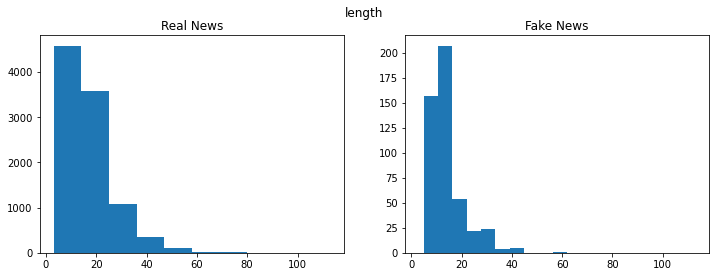

In [100]:
df['length'] = df['headlines'].apply(lambda x: len(x.split()))
plot_hist_by_outcome(df, 'length', bins=10)

We can see that fake news tend to be slightly shorter in words. This may be because fake news are more likely to be clickbait, and clickbait headlines tend to be shorter. However, this is not a very strong indicator, as the difference is not very significant.

### Add boolean feature that indicate if headline included statistics

In [101]:
def bar_chart_by_outcome(df, col):
    # count % of col values in each outcome
    df = df.groupby([col, 'outcome']).count().reset_index().pivot(index='outcome', columns=col, values='headlines')
    df = df.div(df.sum(axis=1), axis=0) * 100
    df.plot.bar(figsize=(12, 4))
    plt.title('% of {} in each outcome'.format(col))

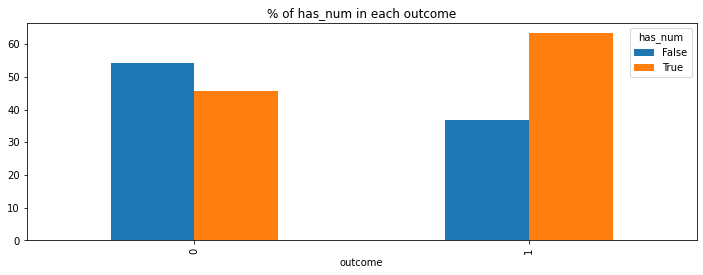

In [102]:
df['has_num'] = df['headlines'].str.contains(r'\d', regex=True)
bar_chart_by_outcome(df, 'has_num')

Seems like fake news are more likely to include statistics in their headlines. Perhaps fake news sites are more likely to use statistics to make their headlines seem more credible.

### Add categorical features with Name-Entity Recognition using SpaCy and extract count of each entity labels

In [103]:
# NEr with spacy
import spacy
from collections import Counter
nlp = spacy.load('en_core_web_sm')

# @np.vectorize
def ner(text):
    doc = nlp(text)
    labels = [X.label_ for X in doc.ents]
    return Counter(labels)

df['ner'] = df['headlines'].apply(ner)
df.head()

C:\Users\Xin Yu\AppData\Roaming\Python\Python39\site-packages\spacy\util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.5.0) was trained with spaCy v3.5 and may not be 100% compatible with the current version (3.3.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


,headlines,outcome,length,has_num,ner
0,A post claims compulsory vacination violates t...,0,30,True,{'ORG': 2}
1,A photo claims that this person is a doctor wh...,0,24,True,"{'ORG': 1, 'FAC': 1, 'GPE': 1}"
2,Post about a video claims that it is a protest...,0,20,False,{'ORG': 1}
3,All deaths by respiratory failure and pneumoni...,0,18,True,{'ORG': 2}
4,The dean of the College of Biologists of Euska...,0,24,False,{'ORG': 2}


In [104]:
labels = [list(c.keys()) for c in df.ner.values]
labels = set([item for sublist in labels for item in sublist])

for label in labels:
    df['ner_' + label.lower()] = df['ner'].apply(lambda x: x.get(label, 0)).sum()
df = df.drop(columns=['ner'])
df.head()
    


,headlines,outcome,length,has_num,ner_WORK_OF_ART,ner_ORDINAL,ner_LANGUAGE,ner_CARDINAL,ner_FAC,ner_PERSON,...,ner_EVENT,ner_MONEY,ner_QUANTITY,ner_LAW,ner_NORP,ner_ORG,ner_PRODUCT,ner_GPE,ner_LOC,ner_DATE
0,A post claims compulsory vacination violates t...,0,30,True,115,196,18,1832,137,3009,...,37,153,40,22,2358,5566,257,5308,192,1315
1,A photo claims that this person is a doctor wh...,0,24,True,115,196,18,1832,137,3009,...,37,153,40,22,2358,5566,257,5308,192,1315
2,Post about a video claims that it is a protest...,0,20,False,115,196,18,1832,137,3009,...,37,153,40,22,2358,5566,257,5308,192,1315
3,All deaths by respiratory failure and pneumoni...,0,18,True,115,196,18,1832,137,3009,...,37,153,40,22,2358,5566,257,5308,192,1315
4,The dean of the College of Biologists of Euska...,0,24,False,115,196,18,1832,137,3009,...,37,153,40,22,2358,5566,257,5308,192,1315


## Class imbalance
Let's do a quick count of the number of examples in each class.

In [118]:
def plot_count_of_each_outcome(df):
    df.groupby('outcome').count().headlines.plot.bar(figsize=(4, 4))
    plt.title('Number of news headlines in each outcome')

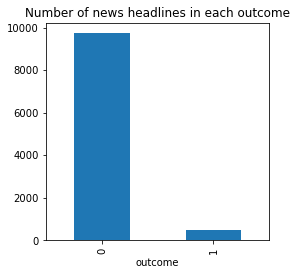

In [119]:
plot_count_of_each_outcome(df)

Oof! Very imbalanced. This tend to result in model having severe bias towards the majority class. We will need to do something about this. One way to do this is to oversample the minority class. We can do this by simply duplicating some of the examples in the minority class. However, this may result in overfitting. Another way is to undersample the majority class. We can do this by simply removing some of the examples in the majority class. However, this may result in loss of information. We will try both methods and see which one works better.

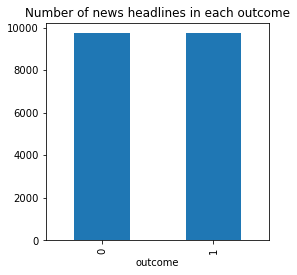

In [120]:
# use smote to oversample outcome == 1 class
from imblearn.over_sampling import RandomOverSampler

X = df.drop(columns=['outcome'])
y = df['outcome']

ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X, y = ros.fit_resample(X, y)

df = pd.concat([X, y], axis=1)
plot_count_of_each_outcome(df)

`# TODO: Insert thanos perfectly balanced meme`